# Predicting Customer Churn Rate in a Telecommunications Company

**'Churn'** is the number or percentage of customers who stop using a company's services during a given period. It is a key performance indicator, especially for subscription services, and is often used synonymously with "customer loss". A high churn rate can indicate problems with customer satisfaction, product quality, or pricing, and is a major concern because it directly impacts revenue and growth.

Project Overview: A telecommunications company wants to understand why customers are leaving its service and predict which customers are most likely to cancel their subscriptions next month.

In [58]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pointbiserialr
from dython.nominal import theils_u

# Data preparation

## Load dataset

In [2]:
# load dataset
churn_data = pd.read_csv('./data/WA_Fn-UseC_-Telco-Customer-Churn.csv')
churn_data.sample(6)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
6566,3795-CAWEX,Male,0,Yes,Yes,70,Yes,Yes,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),116.55,8152.3,No
3510,3199-XGZCY,Female,0,No,No,8,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,75.25,576.7,No
4330,4013-TLDHQ,Male,0,No,No,19,Yes,No,Fiber optic,No,...,Yes,No,No,No,Month-to-month,Yes,Electronic check,78.25,1490.95,Yes
5135,1156-ZFYDO,Female,0,No,No,1,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Electronic check,19.75,19.75,No
1444,5514-YQENT,Male,0,No,Yes,41,Yes,No,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,Two year,Yes,Electronic check,111.15,4507.15,No
1628,6267-DCFFZ,Female,1,Yes,No,30,Yes,Yes,Fiber optic,No,...,No,No,Yes,No,Month-to-month,Yes,Electronic check,90.05,2627.2,No


## Initial exploration and undesrstanding of the data

In [3]:
churn_data.shape

(7043, 21)

In [4]:
churn_data.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

- customerID – Unique identifier for each customer.
- gender – Customer's gender (Male/Female).
- SeniorCitizen – Indicates whether the customer is a senior citizen (1 = Yes, 0 = No).
- Partner – Indicates if the customer has a partner (Yes/No).
- Dependents – Indicates if the customer has dependents (Yes/No).
- tenure – Number of months the customer has been with the company.
- PhoneService – Whether the customer subscribes to phone service (Yes/No).
- MultipleLines – Indicates if the customer has multiple phone lines (Yes/No/No phone service).
- InternetService – Type of internet service subscribed (DSL, Fiber optic, No).
- OnlineSecurity – Indicates whether the customer has online security add-on (Yes/No/No internet service).
- OnlineBackup – Indicates if the customer uses online backup service (Yes/No/No internet service).
- DeviceProtection – Indicates if the customer has device protection (Yes/No/No internet service).
- TechSupport – Indicates if the customer has tech support subscription (Yes/No/No internet service).
- StreamingTV – Indicates if the customer streams TV (Yes/No/No internet service).
- StreamingMovies – Indicates if the customer streams movies (Yes/No/No internet service).
- Contract – Type of contract (Month-to-month, One year, Two year).
- PaperlessBilling – Whether the customer uses paperless billing (Yes/No).
- PaymentMethod – Payment method used by the customer (Electronic check, Mailed check, Bank transfer, Credit card).
- MonthlyCharges – The amount charged to the customer monthly.
- TotalCharges – Total amount charged to the customer over the tenure.
- Churn – Indicates whether the customer has canceled the service (Yes/No).

Numerical columns: `tenure`, `MonthlyCharges`, `TotalCharges`

Ordinal column: `Contract`

Categorical columns: the rest of columns

In [5]:
churn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


If we look at the TotalCharges value, we can see that it was loaded incorrectly and loaded as an object instead of a float.

Let's fix it.

In [6]:
churn_data['TotalCharges'] = pd.to_numeric(churn_data['TotalCharges'], errors='coerce')

In [7]:
churn_data.describe(include='all')

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
count,7043,7043,7043.000000,7043,7043,7043.000000,7043,7043,7043,7043,...,7043,7043,7043,7043,7043,7043,7043,7043.000000,7032.000000,7043
unique,7043,2,NaN,2,2,NaN,2,3,3,3,...,3,3,3,3,3,2,4,NaN,NaN,2
top,7590-VHVEG,Male,NaN,No,No,NaN,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,NaN,NaN,No
freq,1,3555,NaN,3641,4933,NaN,6361,3390,3096,3498,...,3095,3473,2810,2785,3875,4171,2365,NaN,NaN,5174
mean,NaN,NaN,0.162147,NaN,NaN,32.371149,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,2283.300441,NaN
std,NaN,NaN,0.368612,NaN,NaN,24.559481,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,2266.771362,NaN
min,NaN,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,18.800000,NaN
25%,NaN,NaN,0.000000,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,401.450000,NaN
50%,NaN,NaN,0.000000,NaN,NaN,29.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,1397.475000,NaN
75%,NaN,NaN,0.000000,NaN,NaN,55.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,3794.737500,NaN


In [8]:
churn_data.isna().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

## Delete missing and insignificant values

There are 11 NA values. Since these are few samples compared to the total number of samples, which is 7043, deleting these rows with the value NA in the TotalCharges column doesn't change anything; it's an insignificant sample.

In [9]:
churn_data.dropna(axis='index', how='any', inplace=True)
churn_data.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

Let's delete insignificant 'customerID' column:

In [10]:
churn_data.drop(labels='customerID', axis='columns', inplace=True)

## Correlations between features


I wasn't quite sure which methods to use, so I investigated the pandas API, specifically to learn how the `corr()` method works. I saw that it gives us the option to choose between three methods: 
- **Pearson**: It measures the direction and strength of the **linear relationship** between two quantitative variables.
- **Spearman**: It measures the direction and strength of the **monotonic association** between two quantitative variables. (*A monotonic association is a relationship between two variables where they tend to move in the same relative direction, either both increasing or both decreasing.*)
- **Kendall**: It measures the direction and strength of the **monotonic association** between two variables and also serves to measure the **similarity** between two sets of **rankings** given to the same set of objects.

I decided to look into them a bit to know when to use each one (important since we have different types of variables in the dataset). For this reason, I watched the following [video](https://youtu.be/7oGyg8oMFcE?si=YSkH8xWtBC5aBN13) and take notes:

- When to use **Pearson** (assumptions):
    - Interval variables: a numerical variable with a meaningful order and equal, measurable intervals between values, but no true zero point. An example would be the time it takes an athlete to run the 100-meter dash.
    - Ratio variables: Similar to interval variables, but these must have a well-defined zero (for example, weight or height variables). That is, 0 represents the absence of the variable and has no negative values.
    - Linearity: The data must be linear when plotted.
    - Paired data: Each sample must contain both values being compared.
    - No outliers: Pearson's correlation is very sensitive to outliers and would be biased.
    - Bivariate normality: This is the most important assumption. The distribution of both variables must be normal. If we had a bivariate graph, we would obtain a 3D bell curve.
    - Independence of observations 

- When to use **Spearman**:
    - Data not normally distributed.
    - Robust to outliers.
    - In addition to interval and ratio variables, it can be used with ordinal categorical variables.

- When to use **Kendall**:
    - The data do not follow a normal distribution.
    - It is robust to outliers.
    - In addition to interval and ratio variables, it can be used with ordinal categorical variables.
    - Agreement between rankings.
    - Some statisticians prefer Kendall's rank correlation coefficient over Spearman's rank correlation coefficient because they say it performs better with small datasets and is easier to interpret.


For this reason, I can't use any of these methods to calculate the correlation between dependent and independent variables because the dependent variable is categorical (binary).


Investigating a bit more about how to calculate the correlation I made this table:

| Type vs. Type           | Numerical                               | Ordinal categorical           | Nominal categorical                                  |
| ----------------------- |-----------------------------------------| ----------------------------- |------------------------------------------------------|
| **Numerical**           | Spearman (or Pearson when appropriate)  | Spearman                      | ANOVA + η² (eta squared), $r_{pb}$ (binary category) |
| **Ordinal categorical** | Spearman                                | Polychoric, Spearman, Kendall | Chi², Cramer’s V, Theil’s U                          |
| **Nominal categorical** | ANOVA + η², $r_{pb}$ (binary category)  | Chi², Cramer’s V, Theil’s U   | Chi², Cramer’s V, Theil’s U                          |


Lets classify the columns by their types:
- Numerical columns: `tenure`, `MonthlyCharges`, `TotalCharges`
- Ordinal column: `Contract`
- Nominal binary columns: `gender`, `SeniorCitizen`, `Partner`, `Dependents`, `PhoneService`, `PaperlessBilling`, **`Churn`**
- Nominal non-binary columns: `MultipleLines`, `InternetService`, `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, `StreamingMovies`, `PaymentMethod`

First I want to study the correlation between the target variable `Churn` and the other features. So, lets take the last row of the table and apply the appropriate methods.

In [44]:
churn_corr = dict()

dependent_var = 'Churn'
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
ordinal_col = 'Contract'
nominal_binary_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
nominal_non_binary_cols = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaymentMethod']

churn_data_dv_yes_no = churn_data[dependent_var].apply(lambda x: 1 if x == 'Yes' else 0 if x == 'No' else x)

### Correlation between numerical columns and Churn

I will use the point-biserial correlation coefficient ($r_{pb}$).


Let's study the case of `tenure` column.

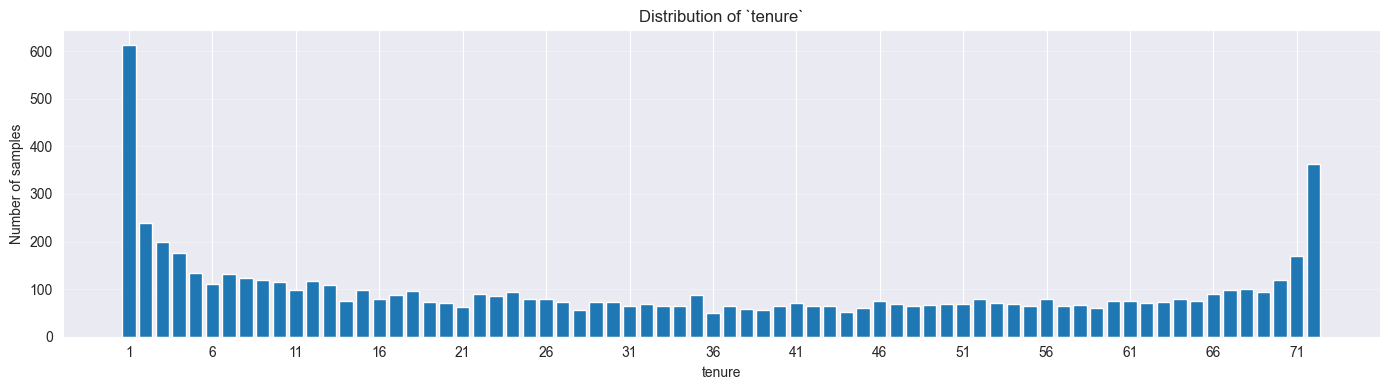

In [45]:
counts = churn_data['tenure'].value_counts().sort_index()

plt.figure(figsize=(14, 4))
plt.bar(counts.index, counts.values)
plt.xticks(range(counts.index.min(), counts.index.max() + 1, 5))  # mostrar etiqueta cada 5 meses
plt.xlabel('tenure')
plt.ylabel('Number of samples')
plt.title('Distribution of `tenure`')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

The shape of the distribution does not invalidate the point-biserial correlation method. The coefficient will still have a clear interpretation: how closely the binary category (e.g., churn vs. no churn) is associated with subscription time.

In [46]:
# pointbiserialr is equivalent to Pearson correlation when one variable is binary, but I will use it for clarity

# tenure vs Churn

corr_tenure, p_value = pointbiserialr(churn_data['tenure'], churn_data_dv_yes_no)
print('Correlation between tenure and Churn:', corr_tenure)
print('P-value:', p_value)

churn_corr['tenure'] = corr_tenure

Correlation between tenure and Churn: -0.354049358953251
P-value: 9.437650217576976e-207


The p-value is so low so we can reject the null hypothesis that there is no correlation between `tenure` and `Churn`. The correlation coefficient is -0.35, indicating a moderate negative correlation. This suggests that as tenure increases, the likelihood of churn decreases.

In [47]:
# MonthlyCharges vs Churn

corr_monthly, p_value = pointbiserialr(churn_data['MonthlyCharges'], churn_data_dv_yes_no)
print('Correlation between MonthlyCharges and Churn:', corr_monthly)
print('P-value:', p_value)

churn_corr['MonthlyCharges'] = corr_monthly

Correlation between MonthlyCharges and Churn: 0.19285821847007883
P-value: 6.760843117978585e-60


The p-value still low soo the null hypothesis can be rejected. The correlation coefficient is 0.19, indicating a weak positive correlation. This suggests that as monthly charges increase, the likelihood of churn slightly increases.

In [48]:
# TotalCharges vs Churn
corr_total, p_value = pointbiserialr(churn_data['TotalCharges'], churn_data_dv_yes_no)
print('Correlation between TotalCharges and Churn:', corr_total)
print('P-value:', p_value)

Correlation between TotalCharges and Churn: -0.19948408356756417
P-value: 4.876865689694556e-64


The p-value is still low soo the null hypothesis can be rejected. The correlation coefficient is -0.19, indicating a weak negative correlation. This suggests that as total charges increase, the likelihood of churn slightly decreases.

#### Correlation between `Contract` ordinal column and Churn

| Goal                                                | Method         | Notes                                                                    |
| --------------------------------------------------- | -------------- | ------------------------------------------------------------------------ |
| Check if there is a significant relationship        | **Chi² test**  | Returns p-value; only tells if relationship exists                       |
| Measure strength of association                     | **Cramer’s V** | 0 = no association, 1 = perfect association; no direction                |
| Measure predictive power / asymmetrical association | **Theil’s U**  | Shows how much one variable predicts the other; useful with ordinal data |


Our goal is to measure how well `Contract` predicts `Churn`, so I will use Theil's U.

If Theil's U is high, the variable has good predictive power → it is worth including it in the model.

In [60]:
# Contract vs Churn

theil_u_value = theils_u(churn_data[ordinal_col], churn_data[dependent_var])
print(f"Theil's U between Contract and Churn: {theil_u_value}")

churn_corr['Contract'] = theil_u_value

Theil's U between Contract and Churn: 0.09837012409876936


---

### Revisar si se puede aprovechar algo de aquí:

In [11]:
plt.figure(figsize=(12, 6))
corr = churn_data.corr()['Churn_Yes'].drop(['Churn_No', 'Churn_Yes'])
plt.bar(corr.index, corr)
plt.xticks(rotation=90)
plt.title('Correlation of Churn with other features', fontsize=16)
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient')
plt.axhline(y=0.2, color='r', linestyle='--', linewidth=1)
plt.axhline(y=-0.2, color='r', linestyle='--', linewidth=1)
plt.show()

ValueError: could not convert string to float: 'Female'

<Figure size 1200x600 with 0 Axes>

## Convert categorical columns to numerical
Firstly, I observed that the column 'Contract' has an ordinal relationship.

In [34]:
churn_data['Contract'].unique()

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

 Therefore, I will map its values to numerical values as follows:
- `Month-to-month = 1`
- `One year = 12`
- `Two year = 14`

I decided to assign 12 and 24 to 'One year' and 'Two year', respectively, to reflect the number of months in each contract type. With this mapping, we use the same metric (months) for the values in the column.

In [35]:
mappint = {
    'Month-to-month': 1,
    'One year': 12,
    'Two year': 24
}
churn_data['Contract'] = churn_data['Contract'].map(mappint)
churn_data['Contract'].unique()

array([ 1, 12, 24])

For the other categorical columns that don't have an ordinal relationship, I will use one-hot encoding. I have chosen this method because the cardinality of these columns is low. If we had high cardinality, we could use target encoding or frequency encoding.

The data types for the columns are now as follows:

In [36]:
churn_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7032 non-null   object 
 1   SeniorCitizen     7032 non-null   int64  
 2   Partner           7032 non-null   object 
 3   Dependents        7032 non-null   object 
 4   tenure            7032 non-null   int64  
 5   PhoneService      7032 non-null   object 
 6   MultipleLines     7032 non-null   object 
 7   InternetService   7032 non-null   object 
 8   OnlineSecurity    7032 non-null   object 
 9   OnlineBackup      7032 non-null   object 
 10  DeviceProtection  7032 non-null   object 
 11  TechSupport       7032 non-null   object 
 12  StreamingTV       7032 non-null   object 
 13  StreamingMovies   7032 non-null   object 
 14  Contract          7032 non-null   int64  
 15  PaperlessBilling  7032 non-null   object 
 16  PaymentMethod     7032 non-null   object 
 17  

It's useful to know that because we can apply one-hot encoding directly using the `pd.get_dummies()` function, which automatically detects categorical columns based on their data types. With the `columns=None` parameter, it will apply one-hot encoding to all columns with the 'object', 'string', or 'category' data type. For the moment I will use `drop_first=Frue` with the objective of studying the correlations between the features. Later, when deciding which columns to keep for the model, I'll see if I should apply `drop_first=True` or delete the redundant columns manually to avoid multicollinearity.

In [37]:
churn_data = pd.get_dummies(churn_data, drop_first=False, columns=None)

In [38]:
churn_data.columns

Index(['SeniorCitizen', 'tenure', 'Contract', 'MonthlyCharges', 'TotalCharges',
       'gender_Female', 'gender_Male', 'Partner_No', 'Partner_Yes',
       'Dependents_No', 'Dependents_Yes', 'PhoneService_No',
       'PhoneService_Yes', 'MultipleLines_No',
       'MultipleLines_No phone service', 'MultipleLines_Yes',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'InternetService_No', 'OnlineSecurity_No',
       'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
       'OnlineBackup_No', 'OnlineBackup_No internet service',
       'OnlineBackup_Yes', 'DeviceProtection_No',
       'DeviceProtection_No internet service', 'DeviceProtection_Yes',
       'TechSupport_No', 'TechSupport_No internet service', 'TechSupport_Yes',
       'StreamingTV_No', 'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No', 'StreamingMovies_No internet service',
       'StreamingMovies_Yes', 'PaperlessBilling_No', 'PaperlessBilling_Yes',
       'PaymentMet

In [39]:
churn_data.sample(3)

,SeniorCitizen,tenure,Contract,MonthlyCharges,TotalCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,...,StreamingMovies_No internet service,StreamingMovies_Yes,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_No,Churn_Yes
6490,0,26,12,19.40,525.55,False,True,True,False,True,...,True,False,True,False,False,False,False,True,True,False
6324,0,9,1,75.85,647.50,True,False,False,True,False,...,False,False,False,True,False,False,True,False,True,False
1207,0,9,1,69.40,571.45,True,False,True,False,False,...,False,True,False,True,False,True,False,False,True,False


In [17]:
def correlation_matrix(df):
    plt.figure(figsize=(18, 18)) # Opcional: ajusta el tamaño de la figura
    sns.heatmap(
        df.corr(), 
        annot=True, 
        cmap='rocket', 
        fmt=".2f", # Formato de 2 decimales para los números
        linewidths=1, # Opcional: añade líneas entre celdas
        center=0
    )
    plt.title('Correlation Matrix', fontsize=16)

As we can see, all the dummy variables that are related with *No internet service* have a score of correlation of 1 with `InternetService_No`. Therefore, we can drop these columns to avoid multicollinearity.

At the same time, `TotalCharges` and `tenure` have a high correlation score of 0.83. This makes sense because the longer a customer stays with the company, the more they are likely to be charged in total. Since |r| > 0.80, I will opt to remove total_charges because it can mostly be explained with tenure.